This is Indian Bird Species Image Classification.

Dataset is from Kaggle.

Will be using Keras ResNet50.

In [1]:
import tensorflow as tf
tf.__version__ 

2023-03-27 16:54:27.962529: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


'2.9.1'

In [2]:
# Import The Libraries 

from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [3]:
# Import helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, compare_historys

## Getting the dataset

In [4]:
# Paths
train_dir = 'training_set'
test_dir = 'testing_set'

In [5]:
IMAGE_SIZE = [224, 224, 3]

In [6]:
# Setup data inputs
import tensorflow as tf

IMG_SIZE = (224, 224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                               image_size=IMG_SIZE,
                                                               label_mode="categorical",
                                                                batch_size=16)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               image_size=IMG_SIZE,
                                                               label_mode="categorical",
                                                               shuffle=False,
                                                               batch_size=16)

Found 16974 files belonging to 25 classes.


2023-03-27 16:54:42.347298: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-27 16:54:42.576116: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-27 16:54:42.576273: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-27 16:54:42.580275: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow 

Found 5647 files belonging to 25 classes.


In [7]:
# Creat checkpoint callback
checkpoint_path = "25_classes_birds_data_model_checkpoint/checkpoints.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only=True,
                                                        monitor="val_accuracy",
                                                        save_best_only=True)

In [8]:
# Create data augmentation layer
from tensorflow.keras import layers
from tensorflow.keras import Sequential

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    layers.Rescaling(1/255.)
], name="data_augmentation")

In [9]:
base_model = tf.keras.applications.ResNet50V2(include_top=False)

In [10]:
base_model.trainable = False

In [11]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                      

In [12]:
# Setup model architecture with trainable top layres
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # Augment images during training
x = base_model(x, training=False) # put base model in inference mode to set weights frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

In [13]:
# Compile the model
model.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 global_avg_pool_layer (Glob  (None, 2048)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 25)                51225     
                                                                 
Total params: 23,616,025
Trainable params: 51,225
Non-trainab

In [30]:
# Fit the model
base_model_history = model.fit(train_data,
                              epochs=5,
                              validation_data=test_data,
                              validation_steps=int(0.15*len(test_data)),
                              callbacks=[checkpoint_callback, create_tensorboard_callback(dir_name="transfer_learning", experiment_name="base_model")])                               

Saving TensorBoard log files to: transfer_learning/base_model/20230325-194104
Epoch 1/5
 147/1061 [===>..........................] - ETA: 6:31 - loss: 1.9045 - accuracy: 0.4596

2023-03-25 19:42:11.069740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 653/1061 [=================>............] - ETA: 1:59 - loss: 1.2321 - accuracy: 0.6460

2023-03-25 19:44:19.340027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 723/1061 [===================>..........] - ETA: 1:34 - loss: 1.1999 - accuracy: 0.6559

2023-03-25 19:44:30.304354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 737/1061 [===================>..........] - ETA: 1:29 - loss: 1.1962 - accuracy: 0.6563

2023-03-25 19:44:32.126664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1036/1061 [============================>.] - ETA: 5s - loss: 1.1193 - accuracy: 0.6778

2023-03-25 19:45:15.087400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1061/1061 [==============================] - 258s 240ms/step - loss: 1.1141 - accuracy: 0.6797 - val_loss: 0.6189 - val_accuracy: 0.8197
Epoch 2/5
 149/1061 [===>..........................] - ETA: 2:05 - loss: 0.8002 - accuracy: 0.7601

2023-03-25 19:45:43.490045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 653/1061 [=================>............] - ETA: 51s - loss: 0.8443 - accuracy: 0.7460

2023-03-25 19:46:44.964793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 723/1061 [===================>..........] - ETA: 42s - loss: 0.8383 - accuracy: 0.7470

2023-03-25 19:46:53.408959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 738/1061 [===================>..........] - ETA: 40s - loss: 0.8393 - accuracy: 0.7471

2023-03-25 19:46:54.840549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1037/1061 [============================>.] - ETA: 2s - loss: 0.8330 - accuracy: 0.7510

2023-03-25 19:47:28.854373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1061/1061 [==============================] - 132s 124ms/step - loss: 0.8352 - accuracy: 0.7510 - val_loss: 0.7037 - val_accuracy: 0.8005
Epoch 3/5
 148/1061 [===>..........................] - ETA: 1:46 - loss: 0.7627 - accuracy: 0.7766

2023-03-25 19:47:52.400904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 653/1061 [=================>............] - ETA: 47s - loss: 0.7647 - accuracy: 0.7730

2023-03-25 19:48:51.634184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 723/1061 [===================>..........] - ETA: 39s - loss: 0.7676 - accuracy: 0.7733

2023-03-25 19:48:59.746961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 738/1061 [===================>..........] - ETA: 37s - loss: 0.7670 - accuracy: 0.7733

2023-03-25 19:49:01.162377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1036/1061 [============================>.] - ETA: 2s - loss: 0.7598 - accuracy: 0.7748

2023-03-25 19:49:35.758139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1061/1061 [==============================] - 127s 120ms/step - loss: 0.7608 - accuracy: 0.7750 - val_loss: 0.6951 - val_accuracy: 0.8113
Epoch 4/5
 149/1061 [===>..........................] - ETA: 1:43 - loss: 0.6923 - accuracy: 0.7873

2023-03-25 19:49:59.382764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 654/1061 [=================>............] - ETA: 44s - loss: 0.7011 - accuracy: 0.7901

2023-03-25 19:50:54.440943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 723/1061 [===================>..........] - ETA: 37s - loss: 0.7005 - accuracy: 0.7896

2023-03-25 19:51:01.901553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 738/1061 [===================>..........] - ETA: 35s - loss: 0.7053 - accuracy: 0.7886

2023-03-25 19:51:03.542636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1036/1061 [============================>.] - ETA: 2s - loss: 0.7074 - accuracy: 0.7876

2023-03-25 19:51:36.605232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1061/1061 [==============================] - 121s 114ms/step - loss: 0.7079 - accuracy: 0.7875 - val_loss: 0.6636 - val_accuracy: 0.8233
Epoch 5/5
 148/1061 [===>..........................] - ETA: 1:40 - loss: 0.6685 - accuracy: 0.7956

2023-03-25 19:52:00.004902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 654/1061 [=================>............] - ETA: 44s - loss: 0.6950 - accuracy: 0.7923

2023-03-25 19:52:55.047282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 723/1061 [===================>..........] - ETA: 36s - loss: 0.6978 - accuracy: 0.7918

2023-03-25 19:53:02.559556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 737/1061 [===================>..........] - ETA: 35s - loss: 0.6980 - accuracy: 0.7917

2023-03-25 19:53:03.887357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1037/1061 [============================>.] - ETA: 2s - loss: 0.7008 - accuracy: 0.7909

2023-03-25 19:53:36.019627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1061/1061 [==============================] - 119s 112ms/step - loss: 0.7034 - accuracy: 0.7904 - val_loss: 0.5190 - val_accuracy: 0.8702


## Load already saved model

In [16]:
model = tf.keras.models.load_model('bird_clf_resnet50v2_base_model.h5')

In [31]:
# Evaluate on whole test dataset
base_model_results = model.evaluate(test_data)
base_model_results

239/353 [===================>..........] - ETA: 4s - loss: 0.6411 - accuracy: 0.8324

2023-03-25 22:07:56.981868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/353 [====================>.........] - ETA: 4s - loss: 0.6377 - accuracy: 0.8315

2023-03-25 22:07:57.382174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-25 22:07:57.382757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


317/353 [=========================>....] - ETA: 1s - loss: 0.5826 - accuracy: 0.8452

2023-03-25 22:07:59.938045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


353/353 [==============================] - 15s 41ms/step - loss: 0.5703 - accuracy: 0.8505


[0.5703216195106506, 0.8505401015281677]

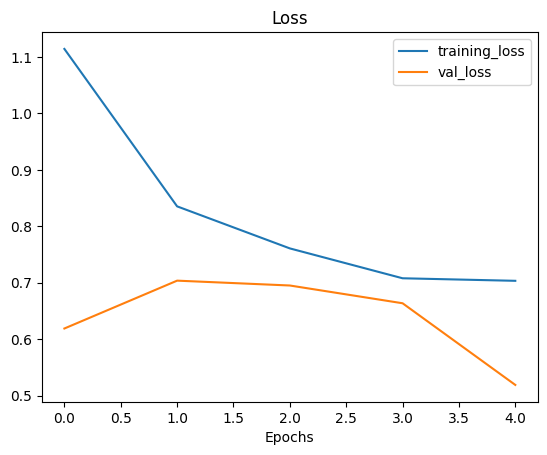

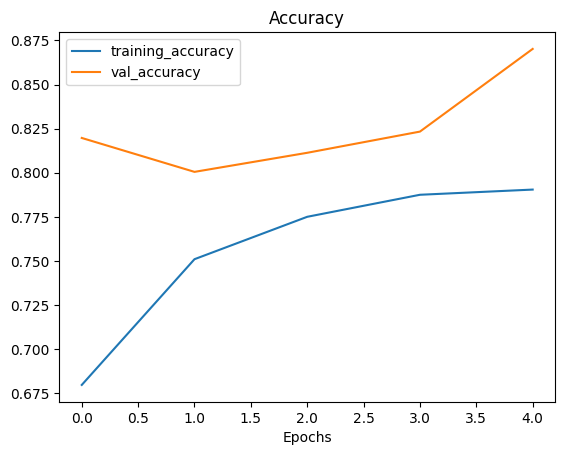

In [32]:
plot_loss_curves(base_model_history)

In [34]:
model.save('bird_clf_resnet50v2_base_model.h5')

## Fine Tuning

In [35]:
# unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [36]:
for i, layer in enumerate(base_model.layers[-10:]):
    print(i, layer.name, layer.trainable)
    

0 conv5_block3_1_bn False
1 conv5_block3_1_relu False
2 conv5_block3_2_pad False
3 conv5_block3_2_conv False
4 conv5_block3_2_bn False
5 conv5_block3_2_relu True
6 conv5_block3_3_conv True
7 conv5_block3_out True
8 post_bn True
9 post_relu True


In [37]:
# Recompiling model with lower learning_rate
model.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             metrics=["accuracy"])

In [38]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 global_avg_pool_layer (Glob  (None, 2048)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 25)                51225     
                                                                 
Total params: 23,616,025
Trainable params: 1,105,945
Non-tr

In [39]:
# Fit the model again
initial_epochs = 5
history_fine_tuned_5_layers_base_model = model.fit(train_data,
                                                 epochs=initial_epochs + 5,
                                                 validation_data=test_data,
                                                 validation_steps=int(0.15 * len(test_data)),
                                                 initial_epoch=base_model_history.epoch[-1],
                                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                       experiment_name="history_fine_tuned_5_layers_base_model")])


Saving TensorBoard log files to: transfer_learning/history_fine_tuned_5_layers_base_model/20230325-221225
Epoch 5/10
 149/1061 [===>..........................] - ETA: 1:20 - loss: 0.6816 - accuracy: 0.8045

2023-03-25 22:12:42.359219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 654/1061 [=================>............] - ETA: 36s - loss: 0.6491 - accuracy: 0.8052

2023-03-25 22:13:27.959570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 724/1061 [===================>..........] - ETA: 30s - loss: 0.6490 - accuracy: 0.8048

2023-03-25 22:13:34.303602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 738/1061 [===================>..........] - ETA: 29s - loss: 0.6512 - accuracy: 0.8048

2023-03-25 22:13:35.709425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1037/1061 [============================>.] - ETA: 2s - loss: 0.6463 - accuracy: 0.8038

2023-03-25 22:14:04.479082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1061/1061 [==============================] - 105s 95ms/step - loss: 0.6477 - accuracy: 0.8035 - val_loss: 0.6056 - val_accuracy: 0.8341
Epoch 6/10
 149/1061 [===>..........................] - ETA: 1:26 - loss: 0.5761 - accuracy: 0.8180

2023-03-25 22:14:24.722775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 654/1061 [=================>............] - ETA: 38s - loss: 0.5824 - accuracy: 0.8182

2023-03-25 22:15:11.905365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 724/1061 [===================>..........] - ETA: 31s - loss: 0.5876 - accuracy: 0.8166

2023-03-25 22:15:18.862209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 737/1061 [===================>..........] - ETA: 30s - loss: 0.5908 - accuracy: 0.8159

2023-03-25 22:15:20.332966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1037/1061 [============================>.] - ETA: 2s - loss: 0.5903 - accuracy: 0.8178

2023-03-25 22:15:49.765409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1061/1061 [==============================] - 105s 99ms/step - loss: 0.5893 - accuracy: 0.8181 - val_loss: 0.6242 - val_accuracy: 0.8257
Epoch 7/10
 149/1061 [===>..........................] - ETA: 1:33 - loss: 0.5326 - accuracy: 0.8372

2023-03-25 22:16:10.908399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 654/1061 [=================>............] - ETA: 38s - loss: 0.5306 - accuracy: 0.8352

2023-03-25 22:16:57.954203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 724/1061 [===================>..........] - ETA: 31s - loss: 0.5325 - accuracy: 0.8341

2023-03-25 22:17:04.041653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 739/1061 [===================>..........] - ETA: 30s - loss: 0.5341 - accuracy: 0.8337

2023-03-25 22:17:05.332037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1037/1061 [============================>.] - ETA: 2s - loss: 0.5326 - accuracy: 0.8346

2023-03-25 22:17:30.655034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1061/1061 [==============================] - 100s 94ms/step - loss: 0.5347 - accuracy: 0.8339 - val_loss: 0.6834 - val_accuracy: 0.8149
Epoch 8/10
 149/1061 [===>..........................] - ETA: 1:17 - loss: 0.5039 - accuracy: 0.8440

2023-03-25 22:17:47.972409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 655/1061 [=================>............] - ETA: 34s - loss: 0.5282 - accuracy: 0.8393

2023-03-25 22:18:30.653364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 724/1061 [===================>..........] - ETA: 28s - loss: 0.5308 - accuracy: 0.8387

2023-03-25 22:18:36.773521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 737/1061 [===================>..........] - ETA: 27s - loss: 0.5307 - accuracy: 0.8388

2023-03-25 22:18:38.025437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1037/1061 [============================>.] - ETA: 2s - loss: 0.5247 - accuracy: 0.8385

2023-03-25 22:19:03.154730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1061/1061 [==============================] - 92s 87ms/step - loss: 0.5256 - accuracy: 0.8385 - val_loss: 0.6116 - val_accuracy: 0.8377
Epoch 9/10
 149/1061 [===>..........................] - ETA: 1:14 - loss: 0.4689 - accuracy: 0.8461

2023-03-25 22:19:19.767984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 654/1061 [=================>............] - ETA: 33s - loss: 0.4956 - accuracy: 0.8443

2023-03-25 22:20:01.945943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 724/1061 [===================>..........] - ETA: 27s - loss: 0.5009 - accuracy: 0.8421

2023-03-25 22:20:07.747920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 738/1061 [===================>..........] - ETA: 26s - loss: 0.5010 - accuracy: 0.8418

2023-03-25 22:20:08.938882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1037/1061 [============================>.] - ETA: 1s - loss: 0.4983 - accuracy: 0.8436

2023-03-25 22:20:33.729428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1061/1061 [==============================] - 91s 86ms/step - loss: 0.4991 - accuracy: 0.8437 - val_loss: 0.6145 - val_accuracy: 0.8365
Epoch 10/10
 150/1061 [===>..........................] - ETA: 1:12 - loss: 0.4393 - accuracy: 0.8700

2023-03-25 22:20:50.549541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 655/1061 [=================>............] - ETA: 33s - loss: 0.4721 - accuracy: 0.8552

2023-03-25 22:21:31.999701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 724/1061 [===================>..........] - ETA: 27s - loss: 0.4721 - accuracy: 0.8549

2023-03-25 22:21:37.710704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 738/1061 [===================>..........] - ETA: 26s - loss: 0.4742 - accuracy: 0.8541

2023-03-25 22:21:38.925911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1037/1061 [============================>.] - ETA: 1s - loss: 0.4698 - accuracy: 0.8567

2023-03-25 22:22:03.679226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1061/1061 [==============================] - 90s 84ms/step - loss: 0.4704 - accuracy: 0.8561 - val_loss: 0.5475 - val_accuracy: 0.8510


In [40]:
# Evaluate on whole test dataset
fine_tune_5_layers_results = model.evaluate(test_data)
fine_tune_5_layers_results

238/353 [===================>..........] - ETA: 4s - loss: 0.5325 - accuracy: 0.8564

2023-03-25 22:42:12.235521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/353 [====================>.........] - ETA: 4s - loss: 0.5237 - accuracy: 0.8580

2023-03-25 22:42:12.702094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-25 22:42:12.703044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


318/353 [==========================>...] - ETA: 1s - loss: 0.4868 - accuracy: 0.8667

2023-03-25 22:42:15.542373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


353/353 [==============================] - 15s 42ms/step - loss: 0.4837 - accuracy: 0.8697


[0.4836820960044861, 0.8696653246879578]

### Load fine-tuned model

In [17]:
model = tf.keras.models.load_model('bird_clf_resnet50v2_fine_tuned_5_layers.h5')

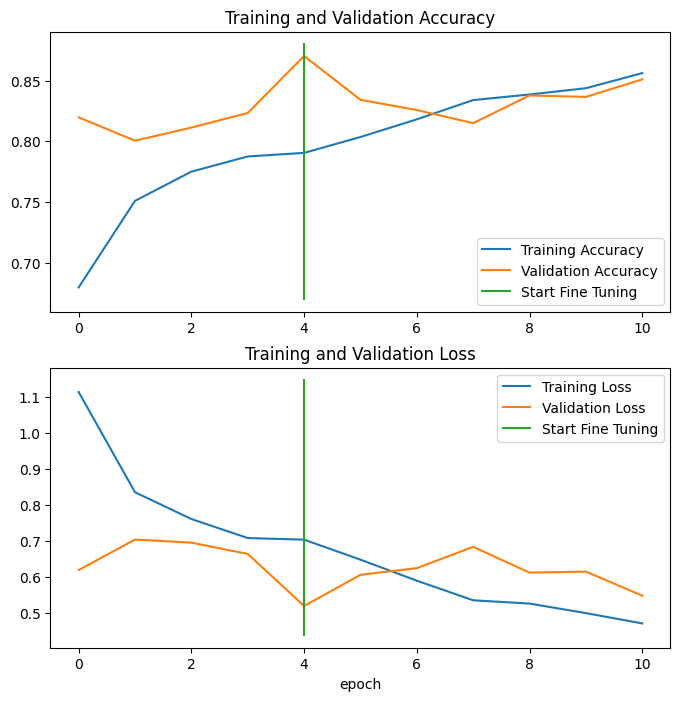

In [41]:
compare_historys(original_history=base_model_history,
                new_history=history_fine_tuned_5_layers_base_model,
                initial_epochs=5)

## Save Model

In [42]:
# Save it as a h5 file
model.save('bird_clf_resnet50v2_fine_tuned_5_layers.h5')

## Predict on Test Model

In [19]:
prediction = model.predict(test_data)

2023-03-27 17:00:43.161745: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8700


  5/353 [..............................] - ETA: 15s   

2023-03-27 17:00:49.511016: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


236/353 [===================>..........] - ETA: 9s

2023-03-27 17:01:09.029162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/353 [===================>..........] - ETA: 9s

2023-03-27 17:01:10.123829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 17:01:10.127873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


315/353 [=========================>....] - ETA: 3s

2023-03-27 17:01:16.864161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


353/353 [==============================] - 46s 92ms/step


In [20]:
prediction

array([[5.54461241e-01, 1.49031673e-02, 3.98048115e-07, ...,
        4.08030010e-09, 1.93979577e-06, 7.68480035e-09],
       [8.02562594e-01, 6.01084717e-02, 8.99316074e-05, ...,
        4.46268350e-05, 1.28758375e-05, 1.05600084e-05],
       [9.99791801e-01, 1.87681762e-05, 1.92540525e-10, ...,
        1.31534453e-12, 1.09426372e-04, 1.28606197e-11],
       ...,
       [3.80305569e-13, 2.92195192e-08, 4.40735420e-07, ...,
        3.23798002e-11, 5.70954590e-08, 9.99963641e-01],
       [1.65266786e-10, 4.21559389e-06, 4.80310518e-06, ...,
        1.59250293e-03, 1.13035803e-07, 9.03271675e-01],
       [3.25193567e-10, 1.61938988e-05, 5.28897763e-05, ...,
        1.69399318e-05, 3.14945625e-10, 9.25176144e-01]], dtype=float32)

In [21]:
prediction = np.argmax(prediction, axis = 1)
prediction

array([ 0,  0,  0, ..., 24, 24, 24])

## Evaluate on the Test Set

In [22]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=0)
print("Loss on test set: {}".format(test_loss))
print("Accuracy on test set: {:.4f}%".format(test_accuracy*100))

2023-03-27 17:02:49.429763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 17:02:50.630209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 17:02:50.635456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-27 17:02:58.225950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Loss on test set: 0.48358264565467834
Accuracy on test set: 86.9488%
